In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
import subprocess 

In [2]:
# Helper function to process a single model (normal or shear)
def _process_single_model(model_path, model_ver, obs_coords):
    """
    Processes a single lens model, runs glafic, and extracts results.

    Args:
        model_path (str): Path to the model directory (e.g., 'NFW', 'NFW+SHEAR').
        model_ver (str): Specific version/run name (e.g., 'NFW_POS+FLUX', 'NFW_POS+FLUX_SHEAR').
        obs_coords (pd.DataFrame): DataFrame with observed positions ('x', 'y') already transformed for plotting.

    Returns:
        tuple: Contains:
            - kappa (np.ndarray): The kappa map data.
            - pred (pd.DataFrame): DataFrame with predicted positions and transformed coords ('x_plot', 'y_plot').
            - model_ver (str): The input model version string (for titles).
            - is_shear (bool): Flag indicating if the model included shear.
    """
    print(f"--- Processing Model: {model_ver} ---")

    is_shear = 'SHEAR' in model_path.upper()

    # --- Determine Constraint Type ---
    if 'POS+FLUX' in model_ver:
        constraint = 'pos_flux'
    elif 'POS' in model_ver:
        constraint = 'pos'
    else:
        # Fallback or raise error if constraint type is unclear
        print(f"Warning: Could not determine constraint type for {model_ver}. Assuming 'pos'.")
        constraint = 'pos' # Or raise ValueError("Cannot determine constraint type")

    # --- File Paths ---
    optresult_file = os.path.join(model_path, f"{model_ver}_optresult.dat")
    # point_py_file = os.path.join(model_path, f"{constraint}_point.py") # Not strictly needed for kappa run
    pred_point_dat_file = os.path.join(model_path, f"{model_ver}_point.dat")
    kappa_base_path = os.path.join('Kappa', model_path, model_ver)
    kappa_fits_file = os.path.join('Kappa', model_path, f"{model_ver}_lens.fits")
    glafic_output_name = f"'Kappa/{model_path}/{model_ver}'" # Name used inside glafic script

    # --- Read Optimization Results ---
    try:
        with open(optresult_file, 'r') as file:
            opt_result = file.readlines()
    except FileNotFoundError:
        print(f"Error: Optimization result file not found: {optresult_file}")
        return None, None, model_ver, is_shear # Return None if file missing

    # --- Extract Lens Parameters ---
    lens_params = {}
    model_input_map = {} # To store mapping like 1 -> 'sie', 2 -> 'pert'

    # Determine primary lens model name
    model_input_1_name_raw = model_path.lower().replace('+shear', '') # Get base model name
    if 'nfw' in model_input_1_name_raw:
        model_input_1_name = 'anfw'
    elif 'c_sie' in model_input_1_name_raw:
        model_input_1_name = 'sie'
    elif 'sie' in model_input_1_name_raw:
         model_input_1_name = 'sie'
    elif 'pow' in model_input_1_name_raw:
         model_input_1_name = 'pow'
    elif 'ein' in model_input_1_name_raw:
         model_input_1_name = 'ein'
    else:
        # Add more mappings or a default/error
        print(f"Warning: Unknown primary lens type in {model_path}. Add mapping.")
        model_input_1_name = model_input_1_name_raw # Use raw name as fallback

    model_input_map[1] = model_input_1_name
    try:
        lens_line_1 = next(line for line in reversed(opt_result) if f'lens   {model_input_1_name}' in line)
        lens_params[1] = lens_line_1.split()[2:]
        print(f"Found primary lens params ({model_input_1_name}): {lens_params[1]}")
    except StopIteration:
        print(f"Error: Could not find lens parameters for '{model_input_1_name}' in {optresult_file}")
        return None, None, model_ver, is_shear

    # Extract shear parameters if needed
    if is_shear:
        model_input_2_name = 'pert'
        model_input_map[2] = model_input_2_name
        try:
            lens_line_2 = next(line for line in reversed(opt_result) if f'lens   {model_input_2_name}' in line)
            lens_params[2] = lens_line_2.split()[2:]
            print(f"Found shear lens params ({model_input_2_name}): {lens_params[2]}")
        except StopIteration:
            print(f"Error: Could not find lens parameters for '{model_input_2_name}' (shear) in {optresult_file}")
            # Decide if this is fatal or if we proceed without shear
            return None, None, model_ver, is_shear

    # Extract Source Position
    try:
        set_point_line = next(line for line in reversed(opt_result) if 'point' in line)
        set_point_values = set_point_line.split()[1:]
        print(f"Found source position params: {set_point_values}")
        if len(set_point_values) != 3:
             raise ValueError(f"Expected 3 values for point source, found {len(set_point_values)}")
    except (StopIteration, ValueError) as e:
        print(f"Error: Could not find or parse source position ('point') in {optresult_file}: {e}")
        return None, None, model_ver, is_shear

    # --- Prepare and Run Glafic ---
    # Create output directory
    os.makedirs(os.path.dirname(kappa_base_path), exist_ok=True)
    # Create the placeholder file glafic needs to write to (optional, glafic might create it)
    # with open(kappa_base_path, 'w') as f: pass # Ensure file path exists

    # Choose and modify the correct glafic template script
    glafic_template_file = 'kappa_shear_glafic.py' if is_shear else 'kappa_glafic.py'
    glafic_run_script = f"run_glafic_{model_ver}.py" # Use a temporary script name

    try:
        with open(glafic_template_file, 'r') as f_template:
            glafic_script_lines = f_template.readlines()
    except FileNotFoundError:
        print(f"Error: Glafic template script not found: {glafic_template_file}")
        return None, None, model_ver, is_shear

    # Modify the script content
    updated_glafic_script = []
    for line in glafic_script_lines:
        if 'glafic.set_lens(1,' in line or (not is_shear and 'glafic.set_lens(' in line):
             # Modify the first (or only) lens component
             params_str = ", ".join(map(str, lens_params[1]))
             line = f"glafic.set_lens(1, '{model_input_map[1]}', {params_str})\n"
             print(f"Updated line: {line.strip()}")
        elif is_shear and 'glafic.set_lens(2,' in line:
             # Modify the second lens component (shear)
             params_str = ", ".join(map(str, lens_params[2]))
             line = f"glafic.set_lens(2, '{model_input_map[2]}', {params_str})\n"
             print(f"Updated line: {line.strip()}")
        elif 'glafic.init(' in line:
            # Update output file name and other potential params
            # Keeping other init params fixed as in the original scripts
            line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {glafic_output_name}, 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n"
            print(f"Updated line: {line.strip()}")
        elif 'glafic.set_point(' in line:
            # Update source position
            line = f"glafic.set_point(1, {set_point_values[0]}, {set_point_values[1]}, {set_point_values[2]})\n" # Assuming format is ID, z, x, y
            print(f"Updated line: {line.strip()}")

        updated_glafic_script.append(line)

    # Write the modified script to a temporary file
    try:
        with open(glafic_run_script, 'w') as f_run:
            f_run.writelines(updated_glafic_script)

        # Run the glafic script using subprocess
        print(f"Running glafic script: {glafic_run_script}...")
        # Use sys.executable to ensure using the correct python interpreter
        # result = subprocess.run([sys.executable, glafic_run_script], capture_output=True, text=True, check=True)
        # print("Glafic stdout:", result.stdout)
        # print("Glafic stderr:", result.stderr)
        # Using %run magic command for compatibility with the original script's environment (e.g., Jupyter)
        # Note: This requires the code to be run in an IPython/Jupyter environment.
        # If running as a standard Python script, switch to subprocess.
        ipython = get_ipython()
        ipython.run_cell(f"%run {glafic_run_script}")
        print("Glafic script finished.")

    except Exception as e:
        print(f"Error running glafic script {glafic_run_script}: {e}")
        # Consider cleaning up the temporary script file
        # if os.path.exists(glafic_run_script): os.remove(glafic_run_script)
        return None, None, model_ver, is_shear
    finally:
        # Clean up the temporary glafic script
        if os.path.exists(glafic_run_script):
             os.remove(glafic_run_script)
             print(f"Removed temporary script: {glafic_run_script}")


    # --- Read Predicted Positions ---
    try:
        pred_columns = ['x', 'y', 'mag', 'delay', 'parity'] # Adjust if columns differ
        # Use sep='\s+' for flexible whitespace separation
        pred = pd.read_csv(pred_point_dat_file, sep='\s+', header=None, skiprows=1, names=pred_columns, comment='#')
        # Apply coordinate transformation (same as for observed)
        pred['x_plot'] = (pred['x'] - 20) / 0.001
        pred['y_plot'] = (pred['y'] - 20) / 0.001
        print(f"Loaded {len(pred)} predicted positions from {pred_point_dat_file}")

        # Optional: Remove 5th image for shear models (if needed)
        # This logic might need adjustment based on how the 5th image is identified
        if is_shear and len(pred) > 4:
             print('Potentially removing 5th image (lowest magnification)')
             # Find index of image with minimum absolute magnification
             # Ensure 'mag' column is numeric
             pred['mag'] = pd.to_numeric(pred['mag'])
             lowest_mag_index = pred['mag'].abs().idxmin()
             print(f"Removing image at index {lowest_mag_index} with mag {pred.loc[lowest_mag_index, 'mag']}")
             pred = pred.drop(lowest_mag_index).reset_index(drop=True)

    except FileNotFoundError:
        print(f"Error: Predicted positions file not found: {pred_point_dat_file}")
        return None, None, model_ver, is_shear
    except Exception as e:
        print(f"Error processing predicted positions file {pred_point_dat_file}: {e}")
        return None, None, model_ver, is_shear


    # --- Read Kappa FITS File ---
    try:
        with fits.open(kappa_fits_file) as hdu_list:
            # Assuming kappa is in the 4th extension (index 3) based on original script
            # Verify this structure if glafic output changes
            if len(hdu_list[0].data) > 3:
                 kappa = np.array(hdu_list[0].data[3])
                 print(f"Loaded kappa map (shape: {kappa.shape}) from {kappa_fits_file}")
            else:
                 print(f"Error: Expected at least 4 data arrays in HDU 0 of {kappa_fits_file}, found {len(hdu_list[0].data)}")
                 return None, pred, model_ver, is_shear # Return pred data even if kappa fails
    except FileNotFoundError:
        print(f"Error: Kappa FITS file not found: {kappa_fits_file}")
        # Still return prediction data if available
        return None, pred, model_ver, is_shear
    except Exception as e:
        print(f"Error reading kappa FITS file {kappa_fits_file}: {e}")
        return None, pred, model_ver, is_shear

    print(f"--- Finished Processing: {model_ver} ---")
    return kappa, pred, model_ver, is_shear


# Main comparison function
def compare_models(model_path_1, model_ver_1, model_path_2, model_ver_2):
    """
    Compares two lens models (normal or shear) side-by-side by plotting their
    kappa maps and overlaying observed/predicted image positions.

    Args:
        model_path_1 (str): Path for model 1 (e.g., 'NFW', 'NFW+SHEAR').
        model_ver_1 (str): Version/run name for model 1 (e.g., 'NFW_POS+FLUX').
        model_path_2 (str): Path for model 2.
        model_ver_2 (str): Version/run name for model 2.
    """

    # --- Load Observed Positions (once) ---
    obs_file = 'obs_point/obs_point_(POS+FLUX).dat'
    try:
        obs = pd.read_fwf(obs_file, header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1)
        plot_obs = obs[['x', 'y', 'm']].copy() # Use .copy() to avoid SettingWithCopyWarning
        # Apply coordinate transformation
        plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
        plot_obs['y'] = (plot_obs['y'] - 20) / 0.001
        print(f"Loaded {len(plot_obs)} observed positions from {obs_file}")
    except FileNotFoundError:
        print(f"Error: Observed positions file not found: {obs_file}")
        return
    except Exception as e:
        print(f"Error processing observed positions file {obs_file}: {e}")
        return

    # --- Process Each Model ---
    results = {}
    models_to_process = {
        1: (model_path_1, model_ver_1),
        2: (model_path_2, model_ver_2)
    }

    for i, (m_path, m_ver) in models_to_process.items():
        kappa, pred, _, is_shear_flag = _process_single_model(m_path, m_ver, plot_obs)
        if kappa is not None and pred is not None:
            results[i] = {'kappa': kappa, 'pred': pred, 'ver': m_ver, 'is_shear': is_shear_flag}
        else:
            print(f"Failed to process model {i} ({m_ver}). Skipping plot for this model.")
            results[i] = None # Mark as failed


    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(22, 10), sharex=True, sharey=True) # Increased size slightly
    axs = axs.flatten() # Ensure axs is always iterable

    plot_titles = {1: model_ver_1, 2: model_ver_2}
    plot_successful = [False, False]

    for i in range(1, 3):
        ax = axs[i-1]
        res = results.get(i)

        if res:
            kappa = res['kappa']
            pred = res['pred']
            ver = res['ver']

            try:
                # Normalize kappa map using LogStretch
                # Add a small epsilon if kappa can be zero or negative
                kappa_min_safe = np.min(kappa[kappa > 0]) if np.any(kappa > 0) else 1e-9
                norm = ImageNormalize(kappa, vmin=kappa_min_safe, stretch=LogStretch(a=1000)) # Adjust 'a' if needed

                im = ax.imshow(kappa, cmap='hot', norm=norm, origin='lower',
                               extent=[0, kappa.shape[1], 0, kappa.shape[0]]) # Use extent for coord matching
                # ax.invert_yaxis() # origin='lower' handles this

                # Logarithmic levels for contours
                kappa_min_log = max(kappa.min(), 1e-6) # Avoid log(0 or negative)
                levels = np.logspace(np.log10(kappa_min_log), np.log10(kappa.max()), 15) # Reduced levels
                contour = ax.contour(
                    kappa,
                    levels=levels,
                    colors='cyan',
                    linewidths=1.0,
                    linestyles='dashed',
                    alpha=1,
                    extent=[0, kappa.shape[1], 0, kappa.shape[0]], # Match imshow extent
                )

                # Plot predicted and observed positions
                # Ensure plot coordinates match the imshow/contour extent
                ax.scatter(plot_obs['x'], plot_obs['y'], s=70, label='Observed', marker='o', alpha=1)
                ax.scatter(pred['x_plot'], pred['y_plot'], c='white', s=90, label='Predicted', marker='x', alpha=1)

                ax.set_title(f'Model: {ver}')
                ax.legend()
                ax.set_xlabel('X (pixels)')
                ax.set_ylabel('Y (pixels)')
                ax.set_aspect('equal', adjustable='box')

                cbar = fig.colorbar(im, ax=ax, label=r'$\kappa$') # Added shrink
                cbar.set_label(r'$\kappa$', rotation=0, labelpad=15, fontsize=12)
                plot_successful[i-1] = True

            except Exception as plot_err:
                 print(f"Error plotting model {i} ({ver}): {plot_err}")
                 ax.set_title(f'Model: {ver}\n(Plotting Failed)')
                 ax.text(0.5, 0.5, 'Plotting Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        else:
            # Handle case where model processing failed
            ax.set_title(f'Model: {plot_titles[i]}\n(Processing Failed)')
            ax.text(0.5, 0.5, 'Processing Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_xlabel('X (pixels)')
            ax.set_ylabel('Y (pixels)')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Add rect to prevent title overlap with suptitle if added
    # Add overall title if desired
    # fig.suptitle("Lens Model Comparison", fontsize=16)
    plt.show()

Loaded 4 observed positions from obs_point/obs_point_(POS+FLUX).dat
--- Processing Model: POW_POS+FLUX ---
Found primary lens params (pow): ['0.2613', '1.000000e+00', '2.080981e+01', '2.076027e+01', '1.164118e-01', '-4.440819e+00', '4.908354e-01', '1.962414e+00']
Found source position params: ['1.0000', '2.081266e+01', '2.077968e+01']
Updated line: glafic.init(0.3, 0.7, -1.0, 0.7, 'Kappa/POW/POW_POS+FLUX', 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)
Updated line: glafic.set_lens(1, 'pow', 0.2613, 1.000000e+00, 2.080981e+01, 2.076027e+01, 1.164118e-01, -4.440819e+00, 4.908354e-01, 1.962414e+00)
Updated line: glafic.set_point(1, 1.0000, 2.081266e+01, 2.077968e+01)
Running glafic script: run_glafic_POW_POS+FLUX.py...


######## writing lens properties
 zs = 1.000000e+00 
 output file name = Kappa/POW/POW_POS+FLUX_lens.fits 



Glafic script finished.
Removed temporary script: run_glafic_POW_POS+FLUX.py
Loaded 4 predicted positions from POW/POW_POS+FLUX_point.dat
Loaded kappa map (shape: (1560, 1560)) from Kappa/POW/POW_POS+FLUX_lens.fits
--- Finished Processing: POW_POS+FLUX ---
--- Processing Model: POW_POS+FLUX_SHEAR ---
Found primary lens params (pow): ['0.2613', '1.000000e+00', '2.081000e+01', '2.076000e+01', '9.364637e-01', '-1.359711e+00', '3.179559e-01', '2.930644e+00']
Found shear lens params (pert): ['0.2613', '1.000000e+00', '2.085513e+01', '2.048605e+01', '1.749327e-02', '1.718205e+02', '0.000000e+00', '5.887661e-01']
Found source position params: ['1.0000', '2.084161e+01', '2.061858e+01']
Updated line: glafic.init(0.3, 0.7, -1.0, 0.7, 'Kappa/POW+SHEAR/POW_POS+FLUX_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)
Updated line: glafic.set_lens(1, 'pow', 0.2613, 1.000000e+00, 2.081000e+01, 2.076000e+01, 9.364637e-01, -1.359711e+00, 3.179559e-01, 2.930644e+00)
Updated line: glafic.set_len

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Kappa/POW+SHEAR/POW_POS+FLUX_SHEAR_lens.fits 



Glafic script finished.
Removed temporary script: run_glafic_POW_POS+FLUX_SHEAR.py
Loaded 4 predicted positions from POW+SHEAR/POW_POS+FLUX_SHEAR_point.dat
Loaded kappa map (shape: (1560, 1560)) from Kappa/POW+SHEAR/POW_POS+FLUX_SHEAR_lens.fits
--- Finished Processing: POW_POS+FLUX_SHEAR ---


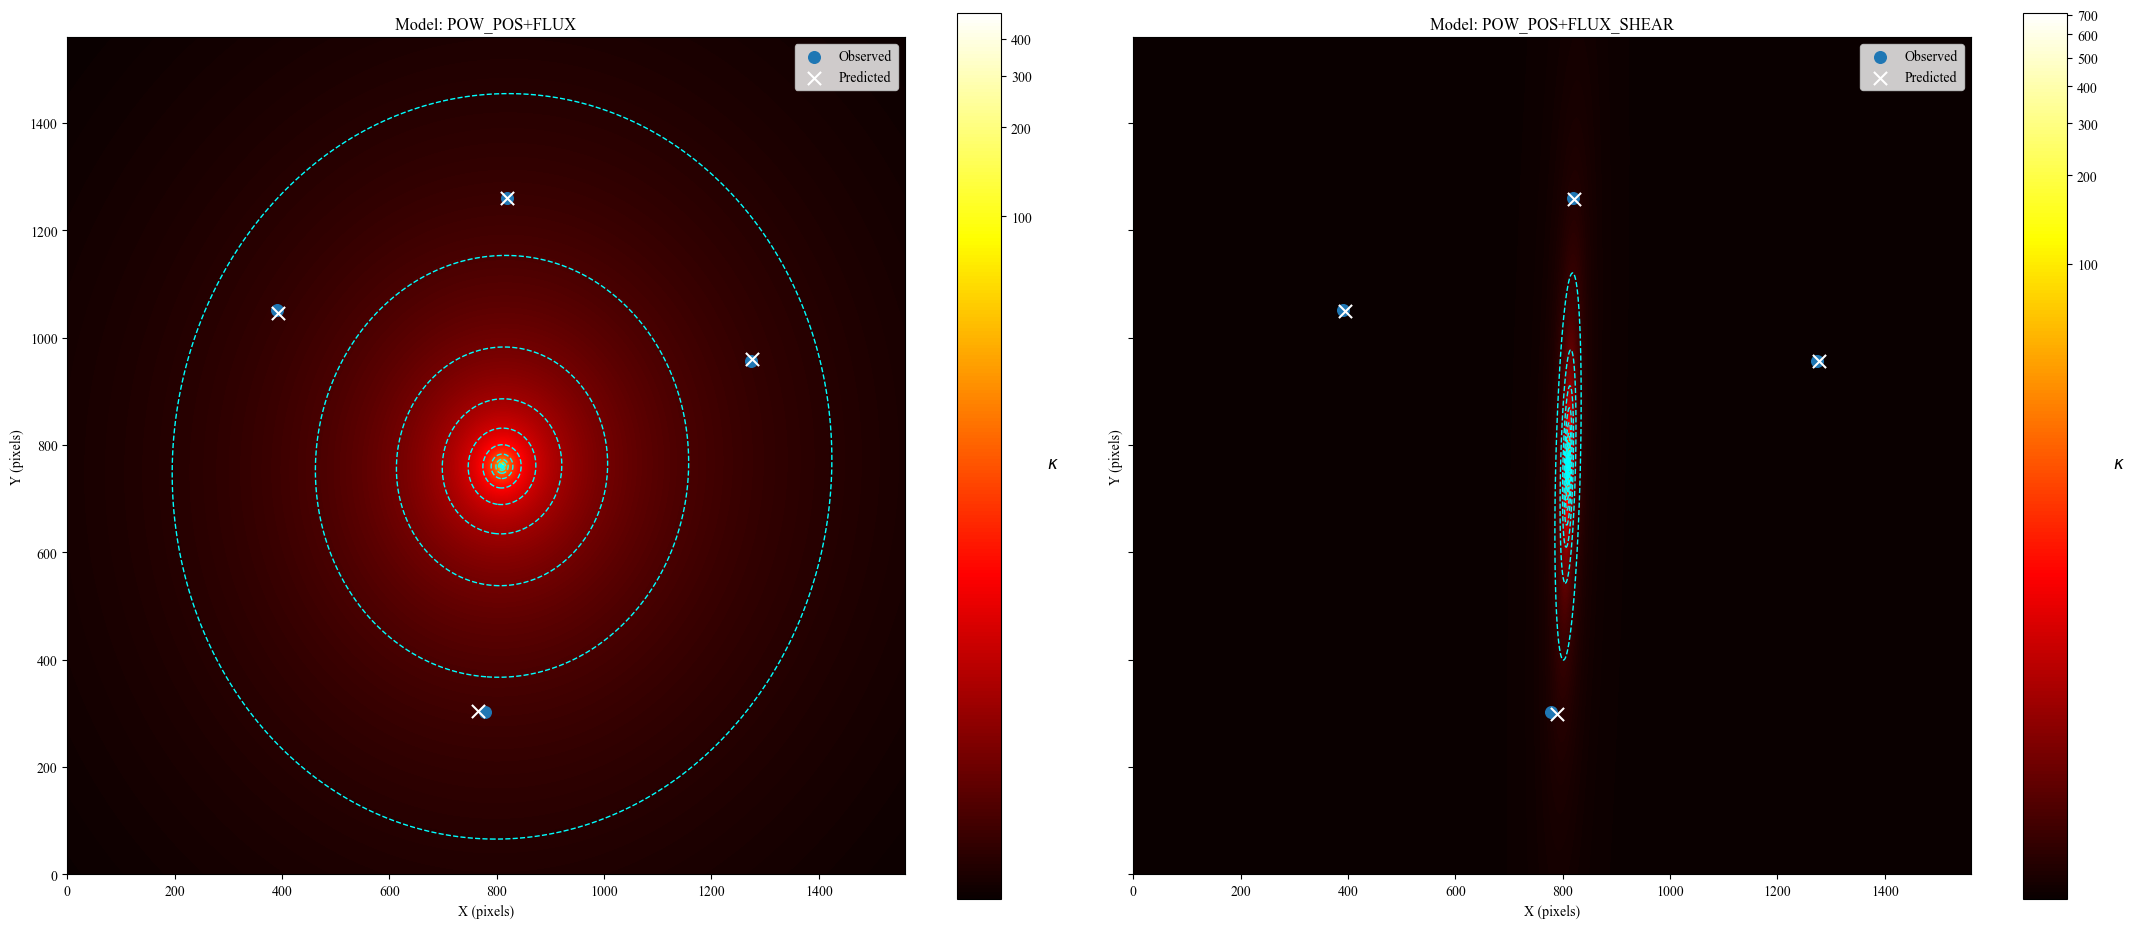

In [94]:
compare_models('POW', 'POW_POS+FLUX', 'POW+SHEAR', 'POW_POS+FLUX_SHEAR')

### Position Vectors

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_50240/2319307530.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_50240/2319307530.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_obs['y'] = (plot_obs['y'] - 20) / 0.001


Found glafic.set_lens
Found glafic.set_point


######## writing lens properties
 zs = 1.000000e+00 
 output file name = Kappa/SIE/SIE_POS_lens.fits 



         x        y      mag    err  x_plot  y_plot
0  20.7645  20.3032  -6.6948  1.051   764.5   303.2
1  21.2761  20.9608  13.6373  0.000  1276.1   960.8
2  20.3933  21.0459  15.4906  0.056   393.3  1045.9
3  20.8199  21.2593 -19.6275  0.169   819.9  1259.3


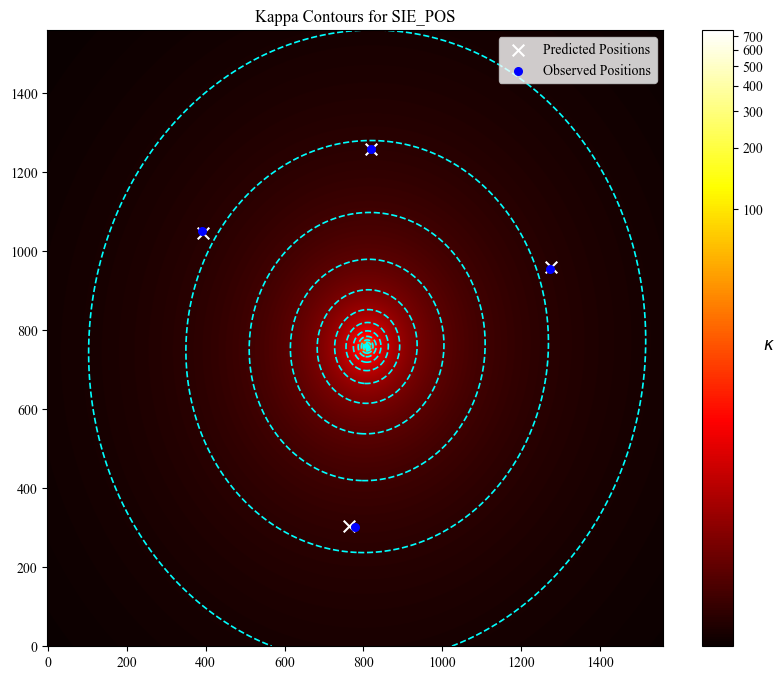

In [4]:
# Model Opening
model_path = 'Test/SIE'
model_ver = 'SIE_POS'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
    py = file.readlines()

# Observed Positions 
obs = pd.read_fwf('obs_point/obs_point_(POS+FLUX).dat', header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1)

plot_obs = obs[['x', 'y', 'm']]
plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
plot_obs['y'] = (plot_obs['y'] - 20) / 0.001

# Extract the line containing 'glafic.startup_setnum('
startup_setnum_line = next(line for line in py if 'glafic.startup_setnum(' in line)

set_point_line = next(line for line in py if 'glafic.set_point(' in line)

# Extract the first number inside the parentheses
extracted_value = int(re.search(r'glafic\.startup_setnum\((\d+)', startup_setnum_line).group(1))

set_point = int(re.search(r'glafic\.set_point\((\d+)', set_point_line).group(1))


# Model Values 
# Find the line containing 'lens   sie' in opt_result
model_path = 'SIE'
model_input = model_path.lower()
if model_input == 'nfw':
    model_input = 'anfw'
if model_input == 'c_sie':
    model_input = 'sie'
if 'SHEAR' in model_path:
    model_input = 'pert'


lens_sie_line = next(line for line in reversed(opt_result) if 'lens   ' + model_input in line)

# Extract the values from the line
lens_sie_values = lens_sie_line.split()[2:]
lens_sie_values = [str(value) for value in lens_sie_values]

# Find the line containing 'glafic.set_point' in opt_result
set_point_line = next(line for line in reversed(opt_result) if 'point' in line)

# Extract the values from the line
set_point_values = set_point_line.split()[1:]
set_point_values = [str(value) for value in set_point_values]


name = "'Kappa/" + model_path + '/' + model_ver + "'"
name

# Check if the file exists, and create it if it doesn't
file_path = 'Kappa/' + model_path + '/' + model_ver
if not os.path.exists(file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'w') as f:
        f.write('')  # Create an empty file

model_input_1 = "'" + model_input + "'"

# Read the existing file contents
with open('kappa_glafic.py', 'r') as f:
    py = f.readlines()

# Update values and write back
with open('kappa_glafic.py', 'w') as glafic_file:
    for line in py:
        if 'glafic.set_lens(' in line:
            print('Found glafic.set_lens')
            line = f"glafic.set_lens(1, {model_input_1}, {lens_sie_values[0]}, {lens_sie_values[1]}, {lens_sie_values[2]}, {lens_sie_values[3]}, {lens_sie_values[4]}, {lens_sie_values[5]}, {lens_sie_values[6]}, {lens_sie_values[7]})\n"
        elif 'glafic.init(' in line:
            line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {name}, 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n"
        elif 'glafic.set_point(' in line:
            print('Found glafic.set_point')
            # Ensure values are up to date
            if set_point_values is not None and len(set_point_values) == 3:
                line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
            else:
                print("set_point_values is not set correctly.")
        glafic_file.write(line)

%run kappa_glafic.py

x_cent = float(set_point_values[1])
y_cent = float(set_point_values[2])

# Predicted Positions 
pred_columns = ['x', 'y', 'mag', 'err']
pred_file = model_path + '/' + model_ver + '_point.dat'
pred = pd.read_fwf(pred_file, sep=' ', header=None, skiprows=1, names=pred_columns)
pred['x_plot'] = (pred['x'] - 20) / 0.001
pred['y_plot'] = (pred['y'] - 20) / 0.001

# Remove the 5th image 
if len(pred) > 4:
    print('Removing the 5th image')
    lowest_mag_index = abs(pred['mag']).idxmin()
    pred = pred.drop(lowest_mag_index)
    pred = pred.reset_index(drop=True)

print(pred)

# FITS File 
image = 'kappa/' + model_path + '/' + model_ver + '_lens' + '.fits'

hdu_list = fits.open(image)

# Extract kappa 
kappa = hdu_list[0].data[3]
kappa = np.array(kappa)

norm = ImageNormalize(kappa, stretch=LogStretch())
plt.figure(figsize=(10, 8))
plt.imshow(kappa, cmap='hot', norm=norm)
plt.gca().invert_yaxis()
cbar = plt.colorbar(label=r'$\kappa$')
cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa.min() + 1e-6), np.log10(kappa.max()), 20)  # Add a small offset to avoid log(0)
contour = plt.contour(
    kappa, 
    levels=levels, 
    colors='cyan', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)

# plt.clabel(contour, inline=True, fontsize=8, fmt='%1.2e', colors='cyan')
plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
plt.title('Kappa Contours for ' + model_ver)
plt.legend()
plt.show()



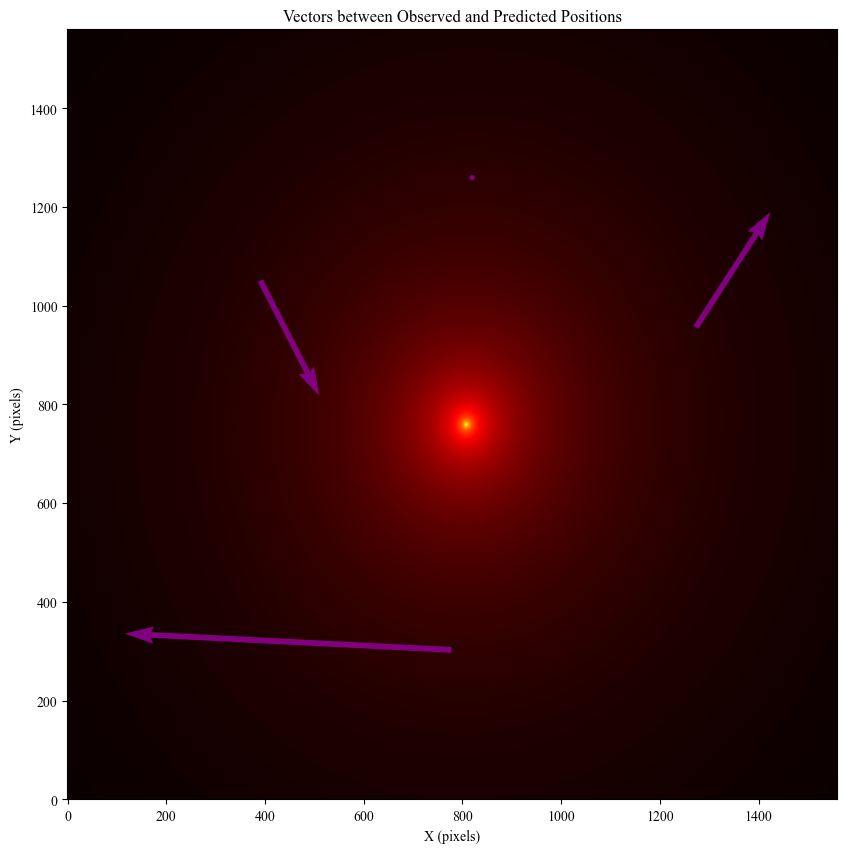

In [5]:
# Vectors between observed and predicted positions
def plot_vectors(obs, pred):
    """
    Plots vectors between observed and predicted positions.

    Args:
        obs (pd.DataFrame): DataFrame with observed positions.
        pred (pd.DataFrame): DataFrame with predicted positions.
    """
    plt.figure(figsize=(12, 10))
    plt.imshow(kappa, cmap='hot', norm=norm)
    plt.gca().invert_yaxis()
    plt.quiver(obs['x'], obs['y'], pred['x_plot'] - obs['x'], pred['y_plot'] - obs['y'], 
               angles='xy', scale_units='xy', scale=0.02, color='purple')  # Decreased scale for larger arrows
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vectors between Observed and Predicted Positions')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.show()

plot_vectors(plot_obs, pred)



In [92]:
model_major = lens_sie_values[5]
model_major = 90 + float(model_major)
model_major

model_minor = lens_sie_values[5]
model_minor = float(model_minor)
model_minor

-4.431327

In [73]:
print(x_cent, y_cent)
x_plot = (x_cent - 20) / 0.001
y_plot = (y_cent - 20) / 0.001
print(x_plot, y_plot)

20.81271 20.77975
812.7099999999991 779.7499999999999


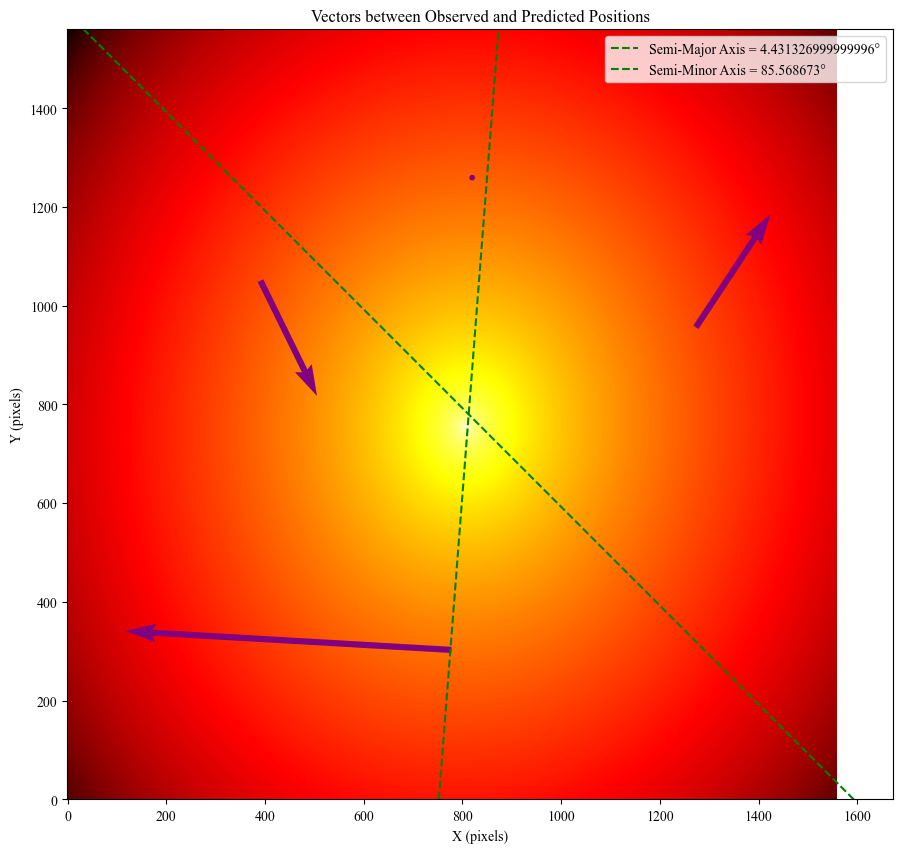

In [93]:
# Vectors between observed and predicted positions
def plot_vectors(obs, pred):
    """
    Plots vectors between observed and predicted positions.

    Args:
        obs (pd.DataFrame): DataFrame with observed positions.
        pred (pd.DataFrame): DataFrame with predicted positions.
    """
    plt.figure(figsize=(12, 10))
    plt.imshow(kappa, cmap='hot', norm=norm)
    plt.gca().invert_yaxis()
    plt.quiver(obs['x'], obs['y'], pred['x_plot'] - obs['x'], pred['y_plot'] - obs['y'], 
               angles='xy', scale_units='xy', scale=0.02, color='purple')  # Decreased scale for larger arrows
    
    # Calculate the slope for the line
    slope = np.tan(np.radians(float(model_major)))
    slope_minor = np.tan(np.radians(float(model_minor)))

    # Adjust y_vals to fit the graph's extent
    y_min, y_max = plt.ylim()
    y_vals = np.linspace(y_min, y_max, 1000)
    x_vals = (y_vals - y_plot) / slope + x_plot  # Center the line on x_cent, y_cent
    
    x_min, x_max = plt.xlim()
    y_vals_minor = (y_vals - y_plot) / slope_minor + y_plot  # Center the line on x_cent, y_cent
    x_vals_minor = (y_vals_minor - y_plot) / slope + x_plot  # Center the line on x_cent, y_cent


    # Plot the line
    plt.plot(x_vals, y_vals, color='green', linestyle='--', label=f'Semi-Major Axis = {90 - model_major}°')
    plt.plot(x_vals_minor, y_vals, color='green', linestyle='--', label=f'Semi-Minor Axis = {model_major}°')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vectors between Observed and Predicted Positions')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.legend()
    plt.show()

plot_vectors(plot_obs, pred)


In [40]:
# Angles between vectors and y-axis
def calculate_angles(obs, pred):
    """
    Calculates angles between vectors and the y-axis.

    Args:
        obs (pd.DataFrame): DataFrame with observed positions.
        pred (pd.DataFrame): DataFrame with predicted positions.

    Returns:
        list: Angles in degrees.
    """
    angles = []
    for i in range(len(obs)):
        dx = pred['x_plot'][i] - obs['x'][i]
        dy = pred['y_plot'][i] - obs['y'][i]
        angle = np.degrees(np.arctan2(dy, dx))
        angles.append(angle)
    return angles
angles = calculate_angles(plot_obs, pred)
print("Angles between vectors and y-axis (degrees):")
for angle in angles:
    print(angle)

Angles between vectors and y-axis (degrees):
176.7122457684265
56.59959522112661
-63.87832949562716
-6.340191745608052
